In [1]:
import torch.nn.functional as F
import torch
from torch import Tensor
from torchvision.transforms.functional import crop, resize

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
from cfa import sparse_ones, rgb_to_cfa, colorize_cfa

In [3]:
import os

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files if not f.endswith(".txt")])
    return res

In [4]:
raw_folder = "../../raw-instinct/16bitRAW"
classes    = os.listdir(raw_folder)
raw_data   = [(c,[np.load(f).astype(np.int32)
                  for f in findAllFiles(os.path.join(raw_folder, c))]) 
              for c in classes]

### Chrominance visualisation

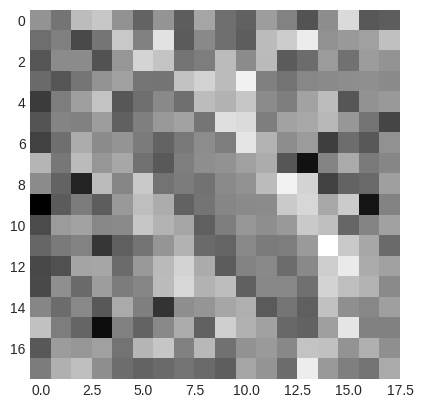

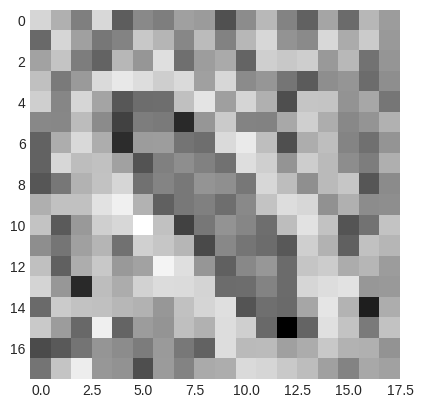

0.5007947087287903 0.3890971839427948


In [5]:
def chroma(mat):
    bayer_k = Tensor(sparse_ones((4,1,2,2), [(0,0,0,1),(1,0,0,0),(2,0,1,0),(3,0,1,1)]))
    rgb_k   = Tensor(sparse_ones((4,3,2,2), [(0,0,0,1),(1,1,0,0),(2,2,1,0),(3,1,1,1)]))
    cr_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,1,0),(0,0,1,0)]))
    cb_k    = Tensor(sparse_ones((2,3,2,2), [(1,1,0,1),(0,2,0,1)]))
    g_int_k = Tensor(sparse_ones((3,3,3,3), [(1,1,0,1),(1,1,1,0),(1,1,1,2),(1,1,2,1)]) * 0.25)
    
    tensor = torch.Tensor(mat).unsqueeze(0)
    
    # CFA 1d -> RGB CFA 3d representation
    conv   = F.conv2d(          tensor, stride=2, weight=bayer_k, padding=1)
    rgb    = F.conv_transpose2d(conv,   stride=2, weight=rgb_k,   padding=1)

    # Interpolate green channel
    bi_g   = F.conv2d(          rgb,              weight=g_int_k, padding=1) + rgb

    # Extract green/red and green/blue
    cr_l   = F.conv2d(          bi_g,   stride=2, weight=cr_k)
    cb_l   = F.conv2d(          bi_g,   stride=2, weight=cb_k)

    c, h, w   = cr_l.shape

    # Calculate chrominance as two maps
    cr     = crop(cr_l[0] / cr_l[1], 1, 1, h-2, w-2)
    cb     = crop(cb_l[0] / cb_l[1], 1, 1, h-2, w-2)

    return cr, cb
    

def chromaMean(mat):
    cr, cb = chroma(mat)
    return torch.mean(cr).item(), torch.mean(cb).item()

# Did not find anything interesting
def chroma90thPercentile(mat):
    cr, cb = chroma(mat)
    return (
        np.percentile(cr.numpy(), 90),
        np.percentile(cb.numpy(), 90)
    )


test = raw_data[0][1][0]

cr, cb = chroma(test)

plt.style.use("seaborn-v0_8-dark")
plt.imshow((cr / cr.max()))
plt.show()
plt.imshow((cb / cb.max()))
plt.show()
print(torch.mean(cr).item(), torch.mean(cb).item())

In [6]:
raw_chroma = [(c, np.array([chromaMean(m) for m in lst])) for (c, lst) in raw_data]

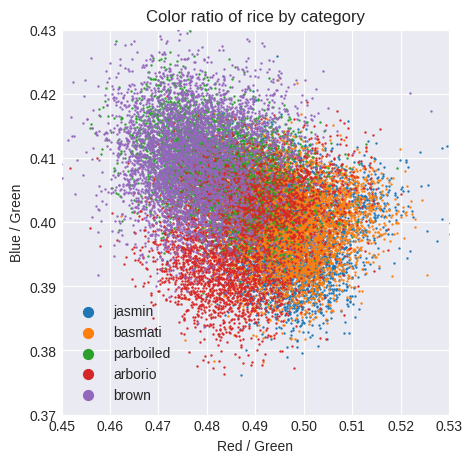

In [7]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("Color ratio of rice by category")
ax.set_ylim([0.37, 0.43])
ax.set_xlim([0.45,  0.53])
ax.set_xlabel("Red / Green")
ax.set_ylabel("Blue / Green")
for (c, lst) in raw_chroma:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

### Value visualisation
Notice that the Arborio rice seperate out from the rest.

In [8]:
raw_min_maxs = [(c, np.array([[np.percentile(np.array(m), 10), 
                               np.percentile(np.array(m), 90)] for m in lst])) for (c, lst) in raw_data]

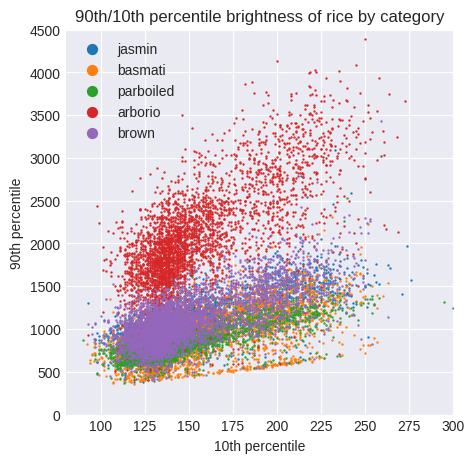

In [9]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("90th/10th percentile brightness of rice by category")
ax.set_ylim([0, 4500])
ax.set_xlim([80, 300])
ax.set_xlabel("10th percentile")
ax.set_ylabel("90th percentile")
for (c, lst) in raw_min_maxs:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

In [10]:
mean_min_maxs = [(c, np.array([[np.mean(np.array(m)[0:12,0:12]), 
                                np.mean(np.array(m)[10:30, 10:30])] for m in lst])) for (c, lst) in raw_data]

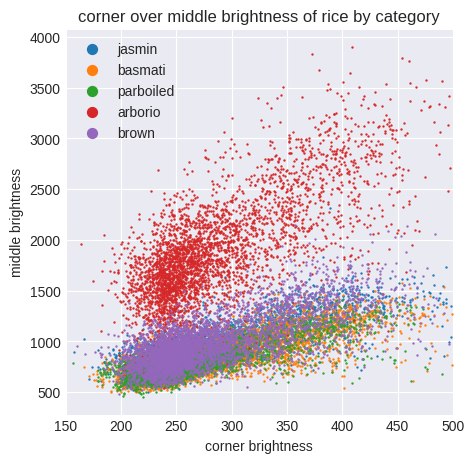

In [11]:
plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("corner over middle brightness of rice by category")
#ax.set_ylim([0, 4500])
ax.set_xlim([150, 500])
ax.set_xlabel("corner brightness")
ax.set_ylabel("middle brightness")
for (c, lst) in mean_min_maxs:
    ax.scatter(*lst.T, s=0.5, label=c)

ax.legend(markerscale=10)

### DNG dataset packing 

In [12]:
import math
import dng

flatten = lambda matrix: [item for row in matrix for item in row]

dataset     = raw_data
layout      = [(c, len(imgs)) for (c, imgs) in raw_data]
imgs        = flatten([imgs for (_, imgs) in dataset])
n_cells     = sum([l for (_, l) in layout])
cell_shape  = (40,40)
padding     = (12,12)
cell_w      = (padding[1]*2 + cell_shape[1])
dng_cells_w = math.ceil(math.sqrt(len(imgs)))
dng_px_w    = dng_cells_w * cell_w

res = np.zeros((dng_px_w, dng_px_w), dtype=np.uint16)

for n, img in enumerate(imgs):
    x = ((n % dng_cells_w)  * cell_w) + padding[0]
    y = ((n // dng_cells_w) * cell_w) + padding[1]
    res[x:x+cell_shape[0], y:y+cell_shape[1]] = img * (2**15 / img.max())

#dng.saveFile(res, "test_dng/rice")

In [13]:
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *
import os

# Test Colour Correction Matrix - 1
ccm1 = [[10000,10000], [10000,10000], [10000,10000],
        [10000,10000], [10000,10000], [10000,10000],
        [10000,10000], [10000,10000], [10000,10000]]

# Test Colour Correction Matrix - 2
# leads to errors
ccm2 = [[0,1], [0,1], [0,1],
        [0,1], [0,1], [0,1],
        [0,1], [0,1], [0,1]]

def saveFile(cfa_img, filename, bpp = 16):
    height, width = cfa_img.shape

    # set DNG tags.
    t = DNGTags()
    #t.set(Tag.ColorMatrix1, ccm1) # colour correction matrix

    t.set(Tag.ImageWidth, width)
    t.set(Tag.ImageLength, height)
    #t.set(Tag.TileWidth, width) # Not supported?
    #t.set(Tag.TileLength, height) # Not supported?
    t.set(Tag.Orientation, Orientation.Horizontal)
    t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
    t.set(Tag.SamplesPerPixel, 1)
    t.set(Tag.BitsPerSample, bpp)
    t.set(Tag.CFARepeatPatternDim, [2,2])
    t.set(Tag.CFAPattern, CFAPattern.GBRG)
    #t.set(Tag.BlackLevel, (4096 >> (16 - bpp))) # def. 0
    #t.set(Tag.WhiteLevel, ((1 << bpp) -1)) # def. 2^bpp -1
    
    #t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65) # def. unknown
    t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]]) # RGB white
    #t.set(Tag.BaselineExposure, [[1, 0]]) # Exposure compensation, defualt 0, repr. 0/1?
    
    t.set(Tag.Make, "No camera - Synthetically generated")
    t.set(Tag.Model, "v1")
    t.set(Tag.DNGVersion, DNGVersion.V1_4)
    t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
    t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

    # save to dng file.
    r = RAW2DNG()
    r.options(t, path="", compress=False) # Enabling compression crashes Jupyter
    r.convert(cfa_img, filename=filename)

for i, img in enumerate(imgs[:3]):
    res = np.ones((230, 230))
    res[95:135, 95:135] = img * (2**15 / img.max())
    print(res.shape)
    saveFile(np.array(res, dtype=np.uint16), f"rice_{i}")

#os.system("rawtherapee-cli -tz -Y -c rice_1.dng rice_2.dng")
os.system("ls")

(230, 230)
(230, 230)
(230, 230)
bayer.ipynb
cfa.py
cfa_test.py
ct-1.png
ct-1.png.out.pp3
ct-ahd-3step-color-supress.png
ct-ahd-3step-color-supress.png.out.pp3
ct.dng
ct.dng.pp3
ct.png
ct.png.out.pp3
custom.dng
custom.dng.pp3
custom.dng.stabil.pp3
dataset-exploration.ipynb
dng
dng.py
im_prep.ipynb
noise.py
PiDNG
pidng_example.py
__pycache__
resnet34-gridsearch.ipynb
rice_0.dng
rice_0.dng.pp3
rice_1.dng
rice_1.dng.pp3
rice_1.jpg
rice_1.tif
rice_2.dng
rice_2.dng.pp3
rice_2.jpg
rice_2.tif
rice_3.dng
rice_3.dng.pp3
rice_4.dng
rice_4.dng.pp3
rice_4.jpg
rice.dng
rice.dng.pp3
scene_daylight_211ms_c2.raw16
teddy-chair-demosaic-1.png
teddy-chair-demosaic-1.png.out.pp3
teddy-chair-demosaic.png
teddy-chair-demosaic.png.out.pp3
teddy-chair.dng
teddy-chair.dng.pp3
test_dng
tiny-imagenet-200
tiny-imagenet-200.zip
tiny_imagenet.pp3


0

#### Color test image

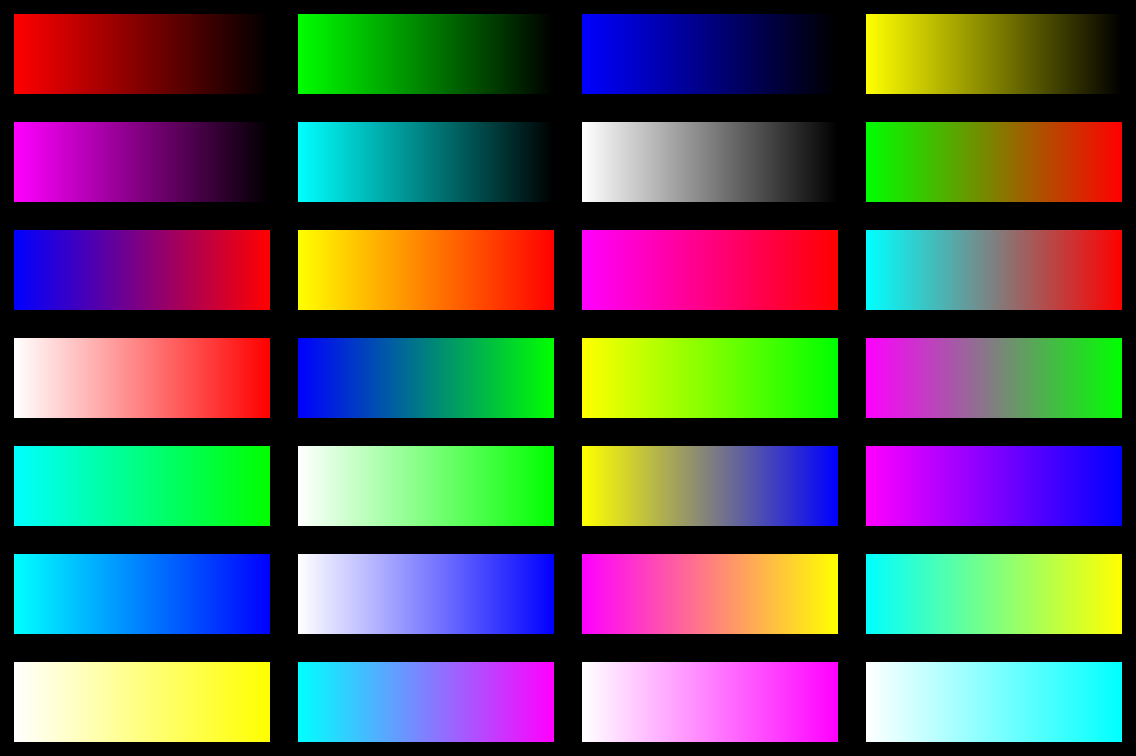

In [14]:
from itertools import chain, combinations, product

# From itertools documentation
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

sweeps = list(combinations(powerset([0,1,2]), 2))

grey   = np.array([128,128,128])

dtype, dt_max, dt_range = np.uint16, 2**16 - 1, 256

pad    = (14,14)
size   = (80, 256)
y_step = pad[1] * 2 + size[1]
x_step = pad[0] * 2 + size[0]

ct_arr = np.zeros((x_step, y_step * len(sweeps), 3), dtype=dtype)

sweep_in  = np.pad(np.broadcast_to(np.linspace(0, dt_max, size[1], dtype=dtype), size), pad)
sweep_out = np.pad(np.broadcast_to(np.linspace(dt_max, 0, size[1], dtype=dtype), size), pad)

for i, (sweep_from, sweep_to) in enumerate(sweeps):
    for c in sweep_from:
        ct_arr[:, i*y_step:(i+1)*y_step, c] += sweep_in
    for c in sweep_to:
        ct_arr[:, i*y_step:(i+1)*y_step, c] += sweep_out

ct_img = np.zeros((x_step * 7, y_step * 4, 3), dtype=dtype)

for i in range(7):
    for j in range(4):
        n = i*4 + j
        ct_img[i*x_step:(i+1)*x_step, j*y_step:(j+1)*y_step] = ct_arr[:, n*y_step:(n+1)*y_step]
    
        
display(Image.fromarray(np.array(ct_img, dtype=np.uint8)))

#### DNG Roundtrip convertion loss

In [15]:
rgb_kf  = sparse_ones((3,2,2), [(0,0,1),(1,0,0),(2,1,0),(1,1,1)])

dng.saveFile(rgb_to_cfa(ct_img, rgb_kf), "ct")

AttributeError: module 'dng' has no attribute 'saveFile'

In [ ]:
img_ct_roundtrip = np.array(Image.open("ct-ahd-3step-color-supress.png"), dtype=np.uint16)

img_ct_diff = (ct_img - img_ct_roundtrip)
display(Image.fromarray((np.abs(img_ct_diff)).astype("uint8")))

#### Noise

255


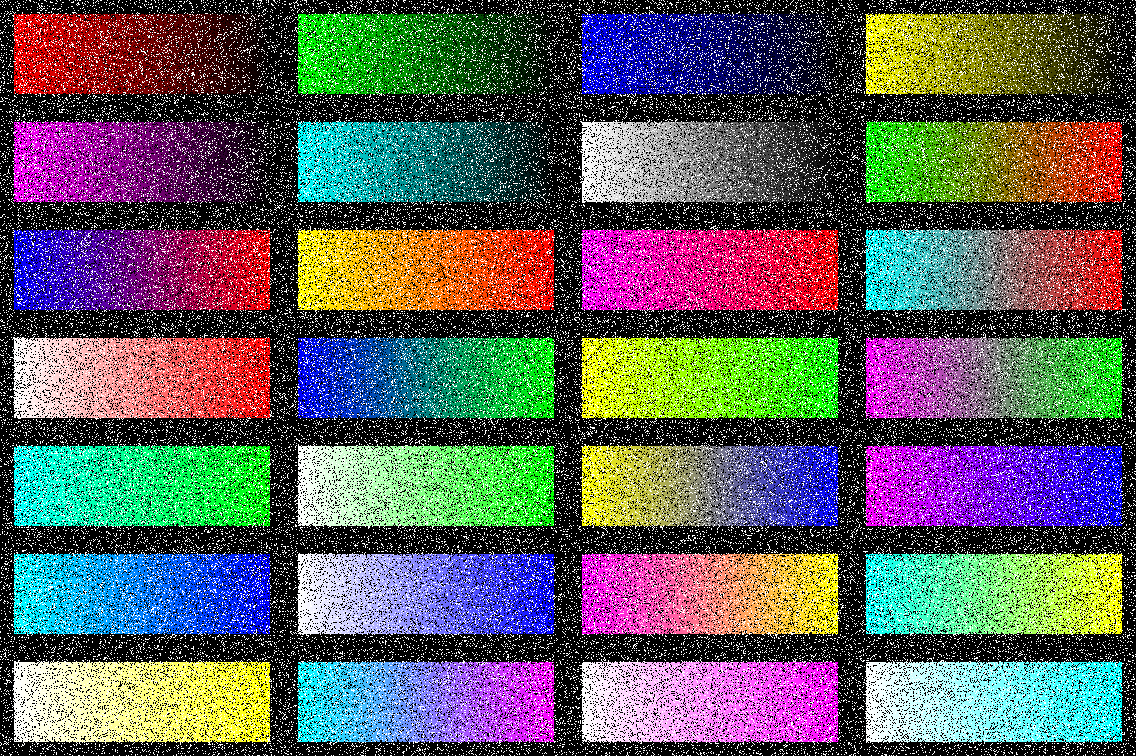

In [40]:
import torch
#from noise import salt_pepper_noise, salt_pepper_noise_torch

img = torch.tensor(np.array(ct_img, dtype=np.uint8), dtype=torch.uint8).permute(2,0,1)




display(Image.fromarray(np.array(salt_pepper_noise_torch(img).permute(1,2,0), dtype=np.uint8)))

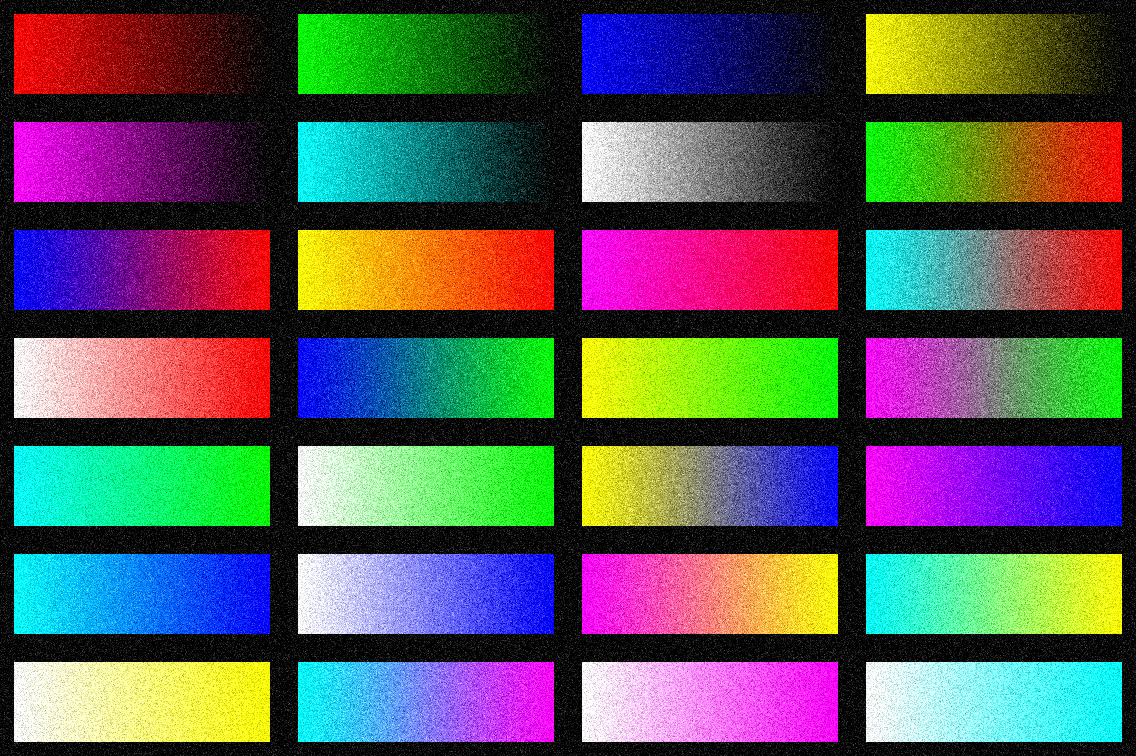

In [16]:
from noise import gaussian_noise

display(Image.fromarray(gaussian_noise(np.array(ct_img, dtype=np.uint8))))